In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table

from sklearn.linear_model import RidgeCV, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
from utils.helper import get_news_scores, add_indicators, trim_df_columns, reg_model_metrics


### Data Preparation

In [3]:
df_stocks = pd.read_csv('data/jpm_bars_2024-02-20.csv')

In [4]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)

In [5]:
df_stocks.tail()

open      high      low   close     volume  trade_count  \
date                                                                    
2024-02-12  174.78  176.8080  173.700  175.79  8539316.0      99614.0   
2024-02-13  175.32  176.2299  172.615  174.26  8397631.0     119866.0   
2024-02-14  175.07  176.1000  174.420  176.03  7056664.0      92056.0   
2024-02-15  176.15  180.2100  176.150  179.87  8723390.0     120899.0   
2024-02-16  179.61  179.9800  178.160  179.03  8292848.0      99541.0   

                  vwap  
date                    
2024-02-12  175.753564  
2024-02-13  174.170059  
2024-02-14  175.386226  
2024-02-15  179.302307  
2024-02-16  178.978772

### Engineering Features

In [6]:
#Add Indicators to stock dataframe
df_stocks_full = add_indicators(df_stocks)

LWMA
VIDYA
KAMA
EVWMA
ALMA
MAMA
EV_MACD
SWI
VORTEX
EVSTC


In [7]:
# Dropping columns with NaN values
df_stocks_full = trim_df_columns(df_stocks_full)

In [8]:
df_stocks_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2031 entries, 2016-01-25 to 2024-02-16
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    2031 non-null   float64
 1   high                    2031 non-null   float64
 2   low                     2031 non-null   float64
 3   close                   2031 non-null   float64
 4   volume                  2031 non-null   float64
 5   trade_count             2031 non-null   float64
 6   vwap                    2031 non-null   float64
 7   SMM_9_period_SMM        2031 non-null   float64
 8   SSMA_9_period_SSMA      2031 non-null   float64
 9   EMA_9_period_EMA        2031 non-null   float64
 10  DEMA_9_period_DEMA      2031 non-null   float64
 11  TEMA_9_period_TEMA      2031 non-null   float64
 12  TRIX_20_period_TRIX     2031 non-null   float64
 13  VAMA_8_period_VAMA      2031 non-null   float64
 14  ER_10_period_ER         2031 n

In [9]:
df_news = pd.read_csv('data/jpm_news_2024-02-20.csv')

In [10]:
df_news.drop(['Unnamed: 0', 'updated_at'], axis=1, inplace=True)
df_news['created_at'] = df_news.created_at.apply(lambda x: x.split(' ')[0])
df_news.rename(columns={'created_at': 'date'}, inplace=True)
df_news = df_news.sort_values('date', ascending=True)
df_news.set_index('date', inplace=True)

In [39]:
df_news.head()

headline summary  \
date                                                                    
2015-01-02  JP Morgan Chase Reports Adjustment to Warrant ...     NaN   
2015-01-05  CNBC Now Tweets: 'BREAKING: Morgan Stanley fir...     NaN   
2015-01-06  Option Alert: JP Morgan Feb $60 Call; 64,626 C...     NaN   
2015-01-06                        Should We Fear A Rate Hike?     NaN   
2015-01-06  JPMorgan Chase Breakup Rumors Start Again As B...     NaN   

                                              url news_type     score  \
date                                                                    
2015-01-02  https://www.benzinga.com/node/5116220  NEGATIVE  0.998391   
2015-01-05  https://www.benzinga.com/node/5119277  NEGATIVE  0.997791   
2015-01-06  https://www.benzinga.com/node/5124585  NEGATIVE  0.988306   
2015-01-06  https://www.benzinga.com/node/5117745  NEGATIVE  0.997089   
2015-01-06  https://www.benzinga.com/node/5124086  NEGATIVE  0.983724   

                                          symbols  
date                                               
2015-01-02                                ['JPM']  
2015-01-05                                ['JPM']  
2015-01-06                                ['JPM']  
2015-01-06                                ['JPM']  
2015-01-06  ['BAC', 'C', 'DB', 'GS', 'JPM', 'MS']

In [11]:
# Getting the news scores regarding the stock
df_score = get_news_scores(df = df_news)

In [12]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1732 entries, 2015-01-02 to 2024-02-14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1732 non-null   float64
 1   news_type  1732 non-null   object 
dtypes: float64(1), object(1)
memory usage: 40.6+ KB


In [13]:
# Adding news scores to stock dataframe
df = pd.concat([df_stocks_full,df_score], axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2364 entries, 2016-01-25 to 2024-02-11
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    2031 non-null   float64
 1   high                    2031 non-null   float64
 2   low                     2031 non-null   float64
 3   close                   2031 non-null   float64
 4   volume                  2031 non-null   float64
 5   trade_count             2031 non-null   float64
 6   vwap                    2031 non-null   float64
 7   SMM_9_period_SMM        2031 non-null   float64
 8   SSMA_9_period_SSMA      2031 non-null   float64
 9   EMA_9_period_EMA        2031 non-null   float64
 10  DEMA_9_period_DEMA      2031 non-null   float64
 11  TEMA_9_period_TEMA      2031 non-null   float64
 12  TRIX_20_period_TRIX     2031 non-null   float64
 13  VAMA_8_period_VAMA      2031 non-null   float64
 14  ER_10_period_ER         2031 n

In [15]:
df.dropna(inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1399 entries, 2016-01-25 to 2024-02-14
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    1399 non-null   float64
 1   high                    1399 non-null   float64
 2   low                     1399 non-null   float64
 3   close                   1399 non-null   float64
 4   volume                  1399 non-null   float64
 5   trade_count             1399 non-null   float64
 6   vwap                    1399 non-null   float64
 7   SMM_9_period_SMM        1399 non-null   float64
 8   SSMA_9_period_SSMA      1399 non-null   float64
 9   EMA_9_period_EMA        1399 non-null   float64
 10  DEMA_9_period_DEMA      1399 non-null   float64
 11  TEMA_9_period_TEMA      1399 non-null   float64
 12  TRIX_20_period_TRIX     1399 non-null   float64
 13  VAMA_8_period_VAMA      1399 non-null   float64
 14  ER_10_period_ER         1399 n

In [17]:
#converting the news_type feature to binary type, POSITIVE = 1 and NEGATIVE = 0 
df['news_type'] = df['news_type'].apply(lambda x:1 if x in ['POSITIVE'] else 0)

In [18]:
df.head()

open   high    low  close      volume  trade_count       vwap  \
2016-01-25  56.48  56.85  55.60  55.66  22118832.0     139637.0  56.137613   
2016-01-26  55.85  57.15  55.81  57.08  19392731.0     107516.0  56.810083   
2016-01-28  57.52  57.97  56.63  57.28  16677125.0     109380.0  57.280159   
2016-02-01  59.16  59.65  58.44  58.86  17857599.0     113520.0  58.885386   
2016-02-02  57.88  57.98  56.75  57.03  24152125.0     137045.0  57.134165   

            SMM_9_period_SMM  SSMA_9_period_SSMA  EMA_9_period_EMA  ...  \
2016-01-25             57.01           57.533632         56.847037  ...   
2016-01-26             57.01           57.474201         56.894979  ...   
2016-01-28             57.01           57.400947         56.997025  ...   
2016-02-01             57.04           57.809081         57.779113  ...   
2016-02-02             57.04           57.714548         57.627896  ...   

            BASP_Buy.  BASP_Sell.  BASPN_Buy.  BASPN_Sell.  \
2016-01-25   1.000000    1.000000    1.000000     1.000000   
2016-01-26   1.747545    0.106348    1.392461     0.530833   
2016-01-28   0.881279    0.732344    1.091190     0.845392   
2016-02-01   0.417583    0.989000    1.330612     0.731779   
2016-02-02   0.414944    1.470925    1.157482     0.871533   

            FISH_10_period_FISH.  APZ_UPPER  APZ_LOWER       VPT_VPT  \
2016-01-25                   0.0  58.160000  53.160000 -2.901991e+07   
2016-01-26                   0.0  59.307392  54.208617  6.581673e+06   
2016-01-28                   0.0  59.939536  54.496688 -8.959114e+05   
2016-02-01                   0.0  61.463578  55.758328  4.251692e+07   
2016-02-02                   0.0  61.063966  55.347324  9.135934e+06   

               score  news_type  
2016-01-25  0.966308          1  
2016-01-26  0.928192          0  
2016-01-28  0.999341          1  
2016-02-01  0.819788          1  
2016-02-02  0.997212          0  

[5 rows x 51 columns]

In [35]:
df.describe()

open         high          low        close        volume  \
count  1399.000000  1399.000000  1399.000000  1399.000000  1.399000e+03   
mean    118.862782   120.031664   117.727861   118.881237  1.583948e+07   
std      29.303266    29.512926    29.105049    29.327735  7.818385e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      98.670000    99.900000    97.120000    98.245000  1.082127e+07   
50%     116.050000   117.180000   114.980000   115.850000  1.414673e+07   
75%     141.755000   143.325000   140.225000   141.920000  1.817264e+07   
max     176.200000   178.300000   174.420000   176.270000  7.290765e+07   

         trade_count         vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
count    1399.000000  1399.000000       1399.000000         1399.000000   
mean   119827.245890   118.880825        118.687169          118.452794   
std     55583.411866    29.320290         29.279979           28.995559   
min         1.000000    53.284123         57.010000           56.749482   
25%     83741.500000    98.494076         98.280000           99.021029   
50%    107609.000000   116.111837        115.550000          115.305490   
75%    138244.000000   142.082344        141.455000          140.970511   
max    457367.000000   175.830884        175.010000          173.865030   

       EMA_9_period_EMA  ...    BASP_Buy.   BASP_Sell.   BASPN_Buy.  \
count       1399.000000  ...  1399.000000  1399.000000  1399.000000   
mean         118.662099  ...     1.088377     1.139932     1.064790   
std           29.150924  ...     1.230687     1.366203     0.355637   
min           56.131166  ...     0.000000     0.000000     0.495873   
25%           98.601924  ...     0.390332     0.350461     0.864351   
50%          115.559896  ...     0.755525     0.725814     0.991621   
75%          141.334766  ...     1.362859     1.399693     1.171298   
max          174.879221  ...    11.932866    13.974026     3.520925   

       BASPN_Sell.  FISH_10_period_FISH.    APZ_UPPER    APZ_LOWER  \
count  1399.000000           1399.000000  1399.000000  1399.000000   
mean      1.085530              0.470810   123.357137   114.344771   
std       0.396875              1.826857    30.205845    28.714439   
min       0.487405             -4.937305    58.160000    52.915044   
25%       0.841774             -0.827991   103.265886    94.343337   
50%       0.990178              0.424144   120.529946   112.072698   
75%       1.229614              1.740069   146.896528   136.914213   
max       3.671142              6.302216   181.176266   171.446342   

            VPT_VPT        score    news_type  
count  1.399000e+03  1399.000000  1399.000000  
mean   3.502695e+08     0.928611     0.572552  
std    3.726057e+08     0.108196     0.494885  
min   -2.482906e+08     0.502791     0.000000  
25%    3.332526e+07     0.913440     0.000000  
50%    2.571804e+08     0.976181     1.000000  
75%    7.247964e+08     0.993851     1.000000  
max    1.113620e+09     0.999861     1.000000  

[8 rows x 51 columns]

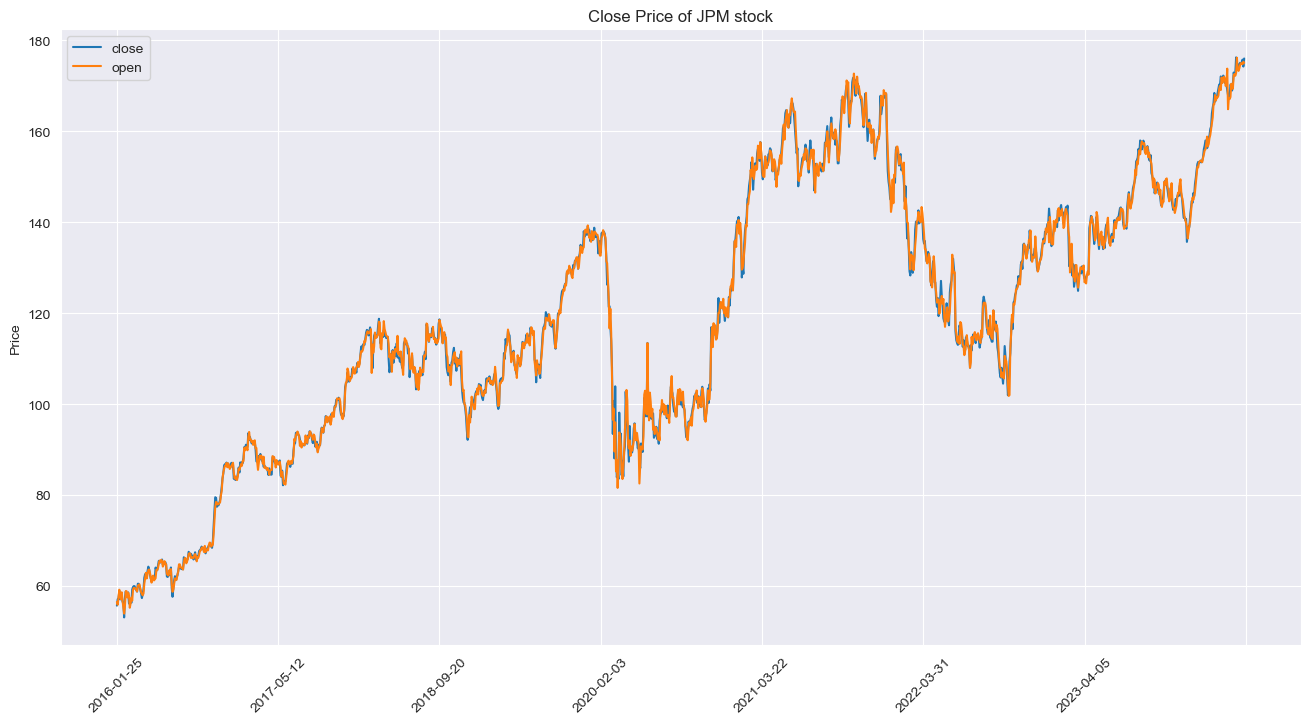

In [20]:
plt.figure(figsize=(16,8))
df['close'].plot(kind='line')
df['open'].plot(kind='line')
plt.xticks(rotation = 45)
plt.title('Close Price of JPM stock')
plt.ylabel('Price')
plt.legend()
plt.show()


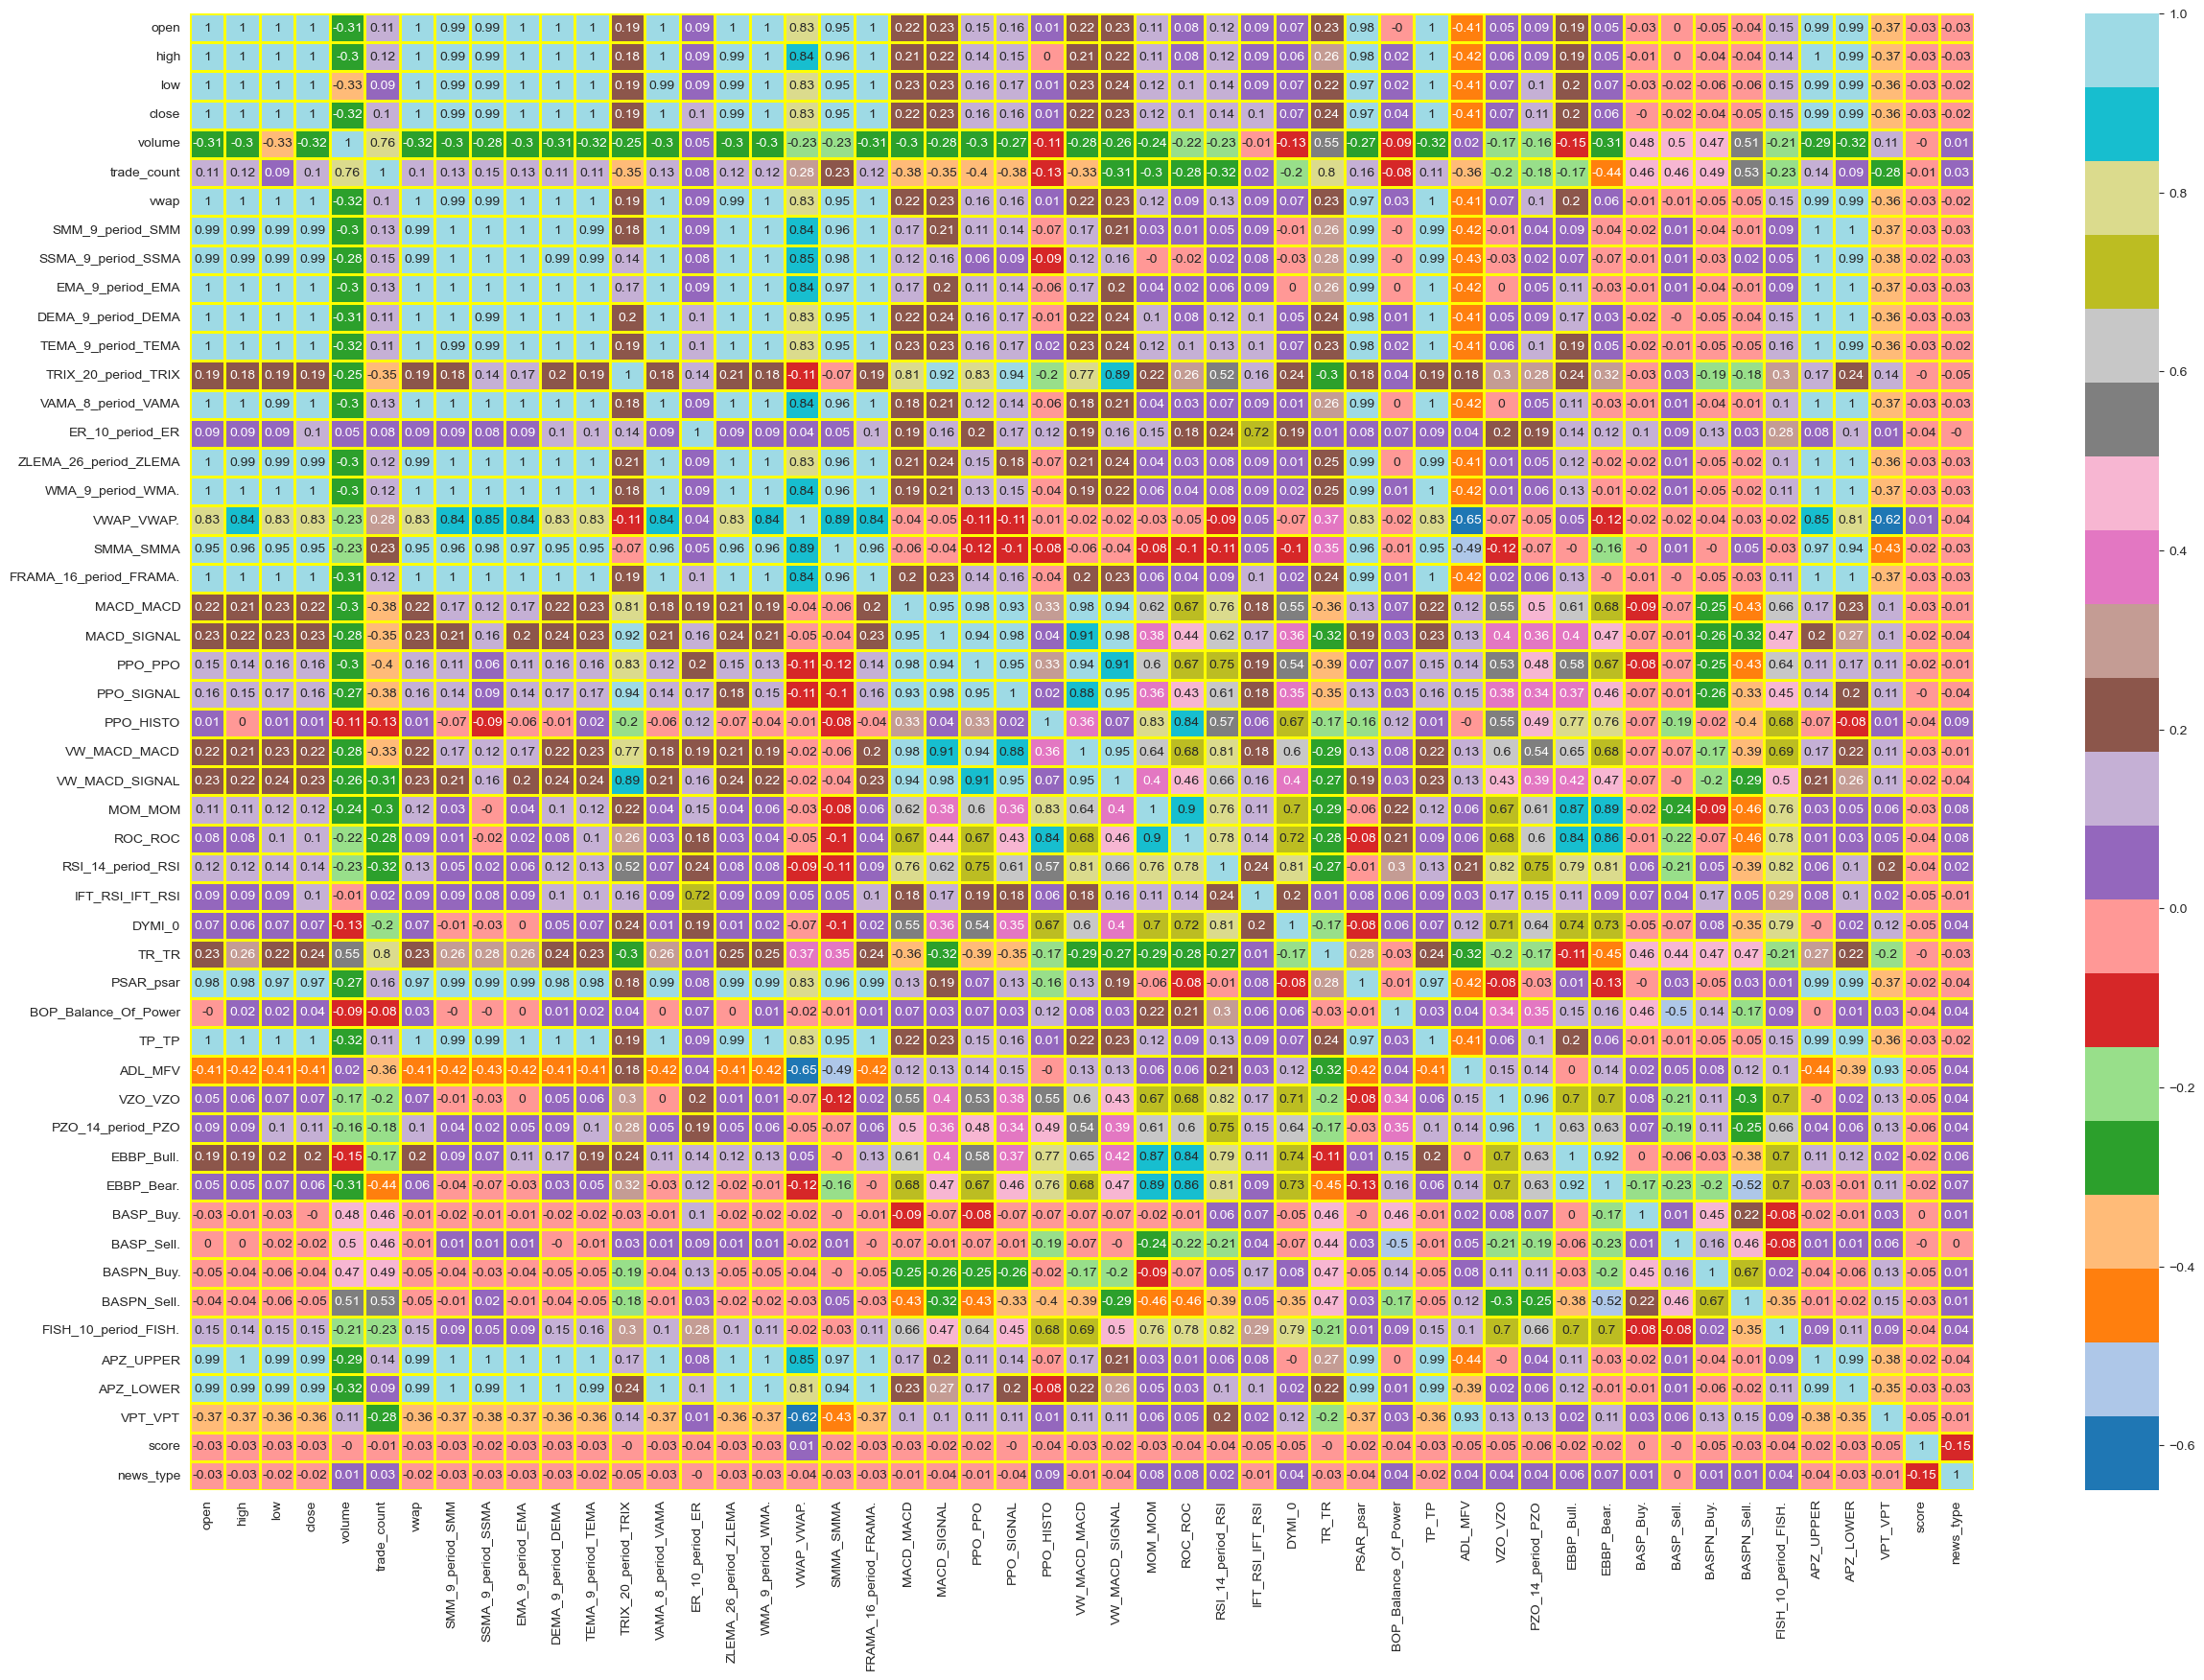

In [21]:
corr =df.corr()
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

#### Removing highly correlated features, the 'close' price is the target feature

In [22]:
low_corr_columns = ['close', 'volume', 'trade_count', 'TRIX_20_period_TRIX', 'ER_10_period_ER', 'PPO_HISTO', 'VW_MACD_MACD', 'MOM_MOM', 'ROC_ROC', 'RSI_14_period_RSI', 'IFT_RSI_IFT_RSI', 'DYMI_0', 'TR_TR',
                    'BOP_Balance_Of_Power', 'ADL_MFV', 'VZO_VZO', 'EBBP_Bull.', 'EBBP_Bear.', 'BASP_Buy.', 'BASP_Sell.', 'BASPN_Buy.', 'BASPN_Sell.', 'VPT_VPT', 'score', 'news_type']

In [23]:
df_corr  = df[low_corr_columns]

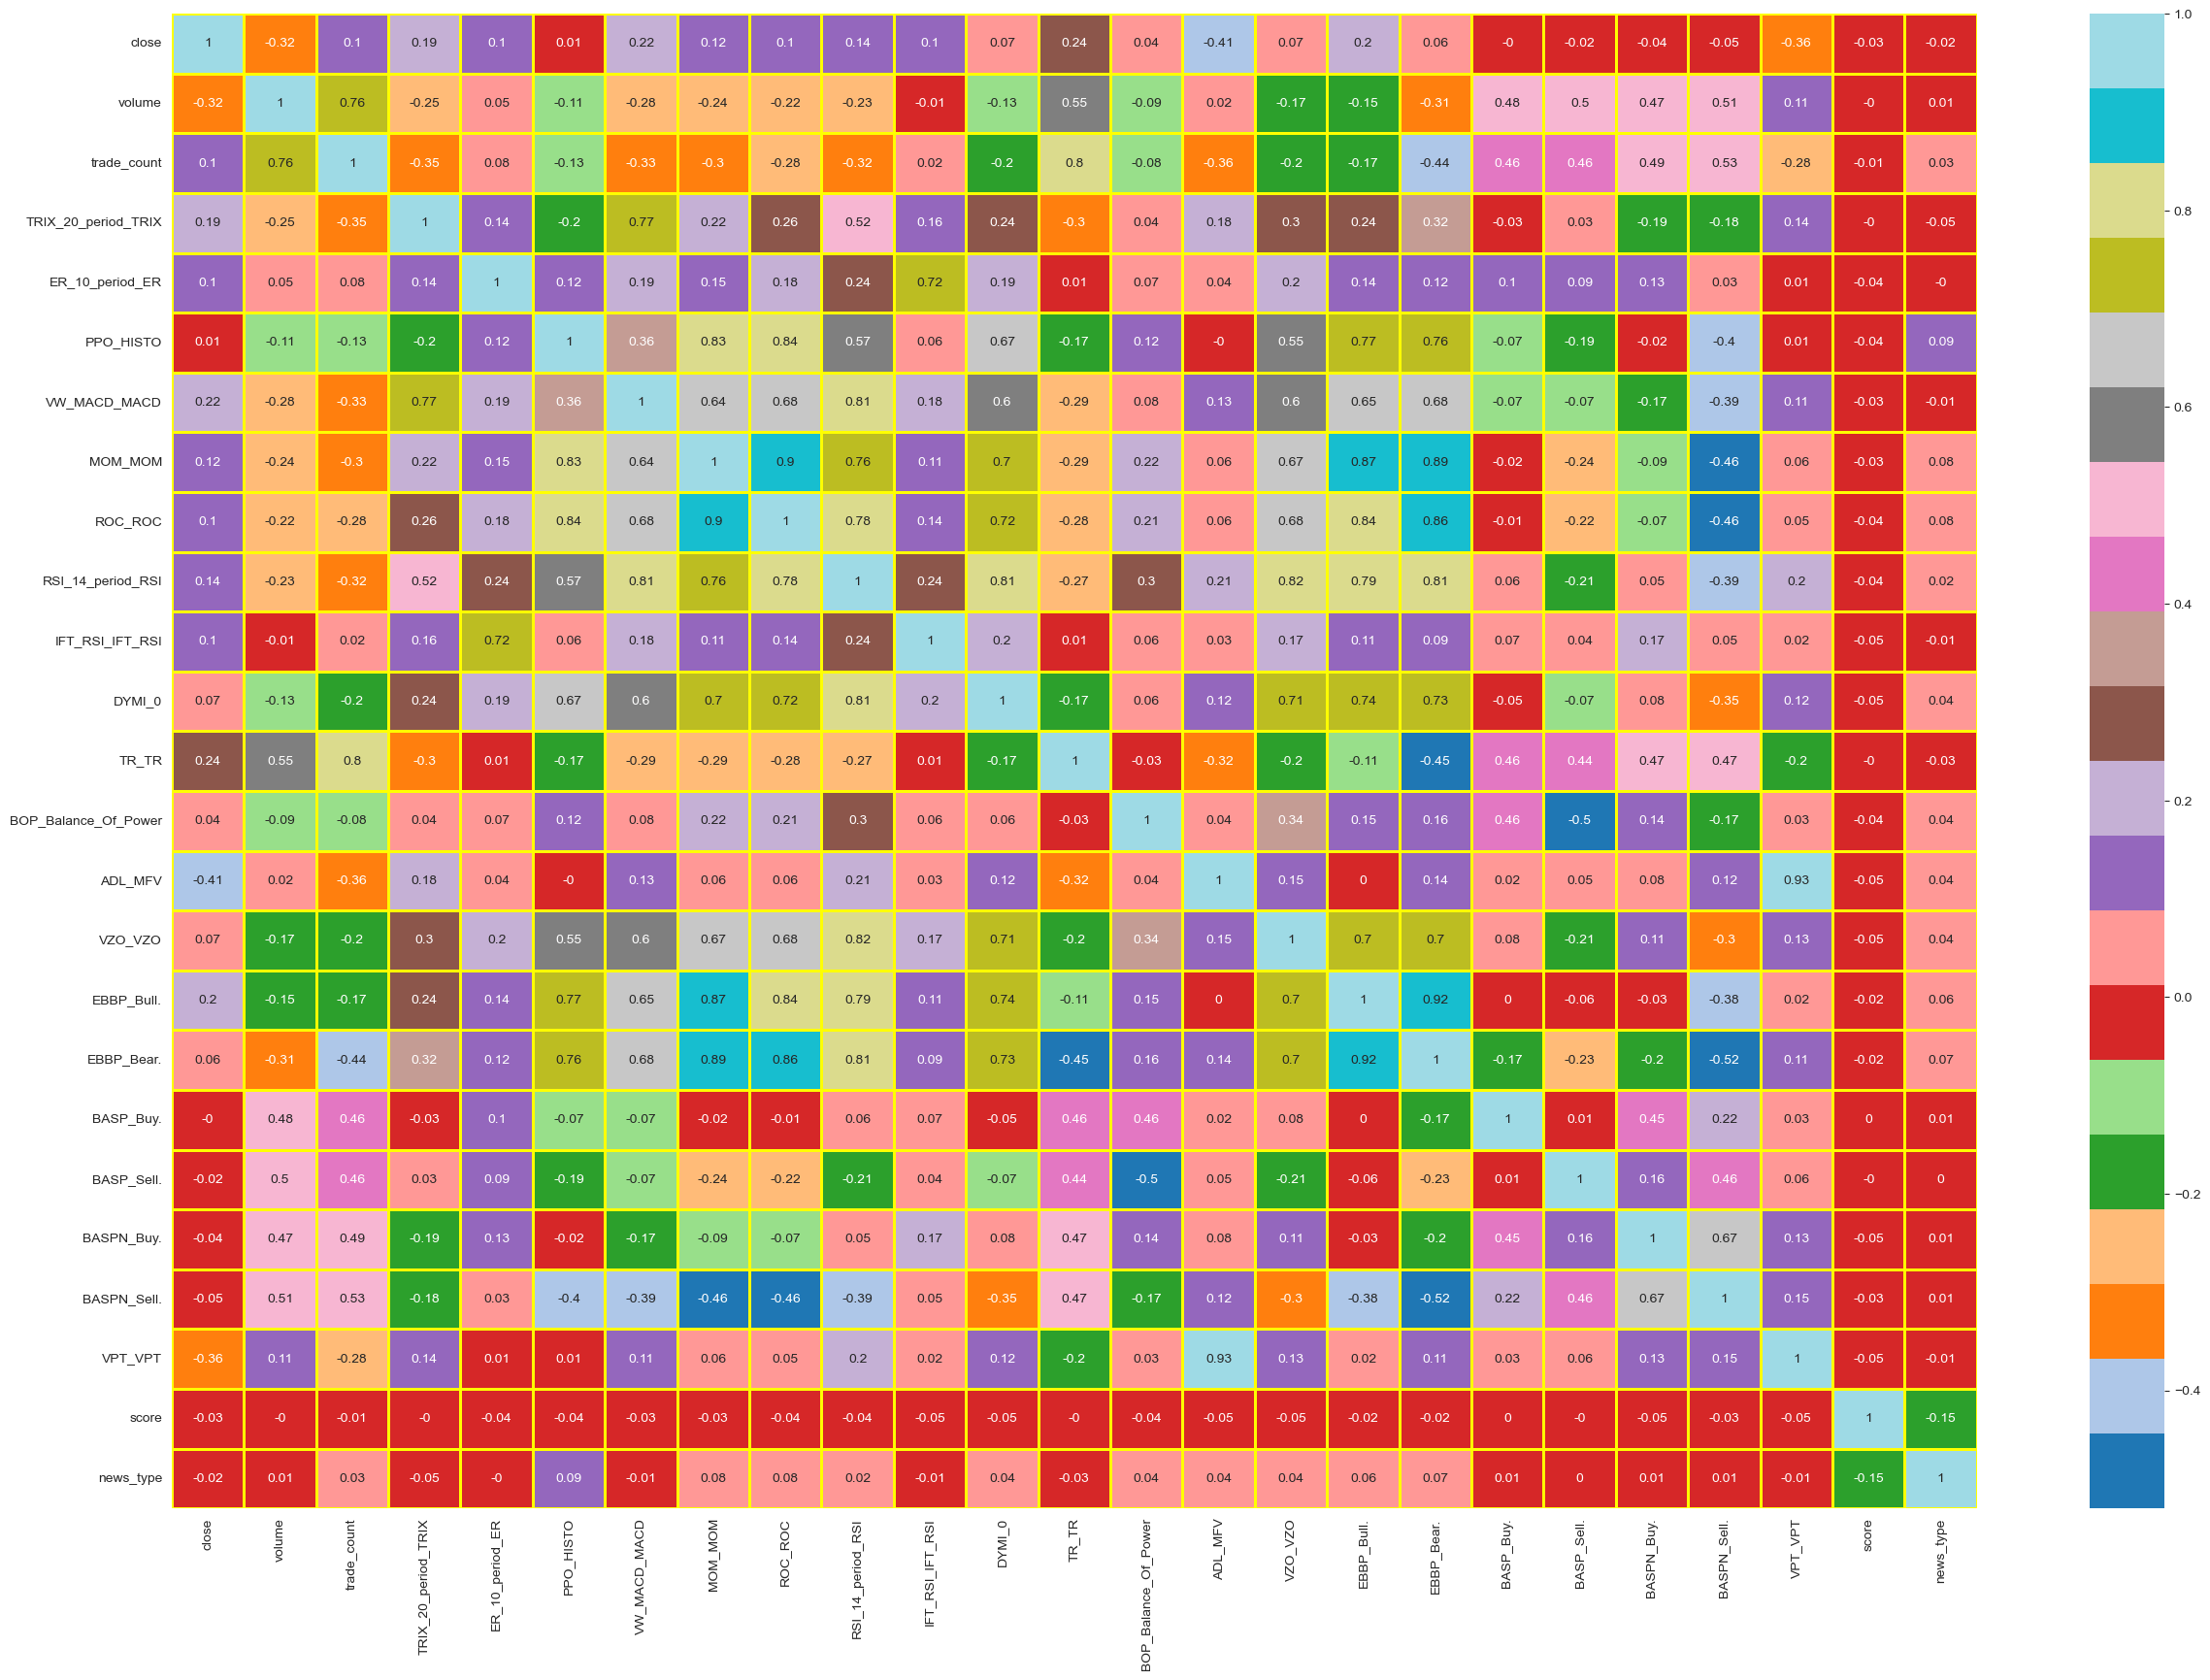

In [24]:
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
corr_low =df_corr.corr()
sns.heatmap(corr_low.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [36]:
df_corr.head()

close      volume  trade_count  TRIX_20_period_TRIX  \
2016-01-25  55.66  22118832.0     139637.0            -0.361674   
2016-01-26  57.08  19392731.0     107516.0            -0.357426   
2016-01-28  57.28  16677125.0     109380.0            -0.339606   
2016-02-01  58.86  17857599.0     113520.0            -0.302403   
2016-02-02  57.03  24152125.0     137045.0            -0.285002   

            ER_10_period_ER  PPO_HISTO  VW_MACD_MACD  MOM_MOM    ROC_ROC  \
2016-01-25         0.377315  -0.255183     -0.632199    -3.26 -11.383538   
2016-01-26         0.175527  -0.108513     -0.583954    -1.75  -5.292849   
2016-01-28         0.007059   0.086908     -0.492193    -0.06  -2.634710   
2016-02-01         0.194861   0.438624     -0.152994     1.82   2.650855   
2016-02-02         0.001795   0.310414     -0.185819     0.02  -2.010309   

            RSI_14_period_RSI  ...    VZO_VZO  EBBP_Bull.  EBBP_Bear.  \
2016-01-25          25.102763  ...   0.000000    1.190000   -0.060000   
2016-01-26          36.044935  ...  50.289241    0.725385   -0.614615   
2016-01-28          37.663164  ...  19.737585    1.116136   -0.223864   
2016-02-01          47.931912  ...  20.927241    1.784242    0.574242   
2016-02-02          40.149127  ...  -6.697647    0.295119   -0.934881   

            BASP_Buy.  BASP_Sell.  BASPN_Buy.  BASPN_Sell.       VPT_VPT  \
2016-01-25   1.000000    1.000000    1.000000     1.000000 -2.901991e+07   
2016-01-26   1.747545    0.106348    1.392461     0.530833  6.581673e+06   
2016-01-28   0.881279    0.732344    1.091190     0.845392 -8.959114e+05   
2016-02-01   0.417583    0.989000    1.330612     0.731779  4.251692e+07   
2016-02-02   0.414944    1.470925    1.157482     0.871533  9.135934e+06   

               score  news_type  
2016-01-25  0.966308          1  
2016-01-26  0.928192          0  
2016-01-28  0.999341          1  
2016-02-01  0.819788          1  
2016-02-02  0.997212          0  

[5 rows x 25 columns]

In [37]:
df_corr.describe()

close        volume    trade_count  TRIX_20_period_TRIX  \
count  1399.000000  1.399000e+03    1399.000000          1399.000000   
mean    118.881237  1.583948e+07  119827.245890             0.042221   
std      29.327735  7.818385e+06   55583.411866             0.222005   
min      53.070000  1.604000e+05       1.000000            -1.037542   
25%      98.245000  1.082127e+07   83741.500000            -0.077172   
50%     115.850000  1.414673e+07  107609.000000             0.062955   
75%     141.920000  1.817264e+07  138244.000000             0.172432   
max     176.270000  7.290765e+07  457367.000000             0.531040   

       ER_10_period_ER    PPO_HISTO  VW_MACD_MACD      MOM_MOM      ROC_ROC  \
count      1399.000000  1399.000000   1399.000000  1399.000000  1399.000000   
mean          0.343729     0.011610      0.495694     0.609492     0.808974   
std           0.236013     0.572201      1.981214     6.455875     5.796433   
min           0.000376    -3.149239     -6.928656   -38.720000   -32.038694   
25%           0.145349    -0.298048     -0.702054    -2.290000    -2.184760   
50%           0.311667     0.007038      0.597857     0.880000     1.054111   
75%           0.509290     0.320007      1.700220     4.180000     4.096501   
max           1.000000     2.693997      5.740988    23.980000    24.219862   

       RSI_14_period_RSI  ...      VZO_VZO   EBBP_Bull.   EBBP_Bear.  \
count        1399.000000  ...  1399.000000  1399.000000  1399.000000   
mean           53.761346  ...     1.032825     1.478990    -0.824813   
std            12.490721  ...    29.045976     3.089909     3.468742   
min            17.787062  ...   -74.469169   -18.529212   -24.759412   
25%            45.011944  ...   -19.214503    -0.053861    -2.178352   
50%            53.330709  ...     0.100792     1.411969    -0.397463   
75%            62.998783  ...    21.829568     3.057574     1.166146   
max            87.416233  ...    83.096700    15.584545    10.213254   

         BASP_Buy.   BASP_Sell.   BASPN_Buy.  BASPN_Sell.       VPT_VPT  \
count  1399.000000  1399.000000  1399.000000  1399.000000  1.399000e+03   
mean      1.088377     1.139932     1.064790     1.085530  3.502695e+08   
std       1.230687     1.366203     0.355637     0.396875  3.726057e+08   
min       0.000000     0.000000     0.495873     0.487405 -2.482906e+08   
25%       0.390332     0.350461     0.864351     0.841774  3.332526e+07   
50%       0.755525     0.725814     0.991621     0.990178  2.571804e+08   
75%       1.362859     1.399693     1.171298     1.229614  7.247964e+08   
max      11.932866    13.974026     3.520925     3.671142  1.113620e+09   

             score    news_type  
count  1399.000000  1399.000000  
mean      0.928611     0.572552  
std       0.108196     0.494885  
min       0.502791     0.000000  
25%       0.913440     0.000000  
50%       0.976181     1.000000  
75%       0.993851     1.000000  
max       0.999861     1.000000  

[8 rows x 25 columns]

<Axes: >

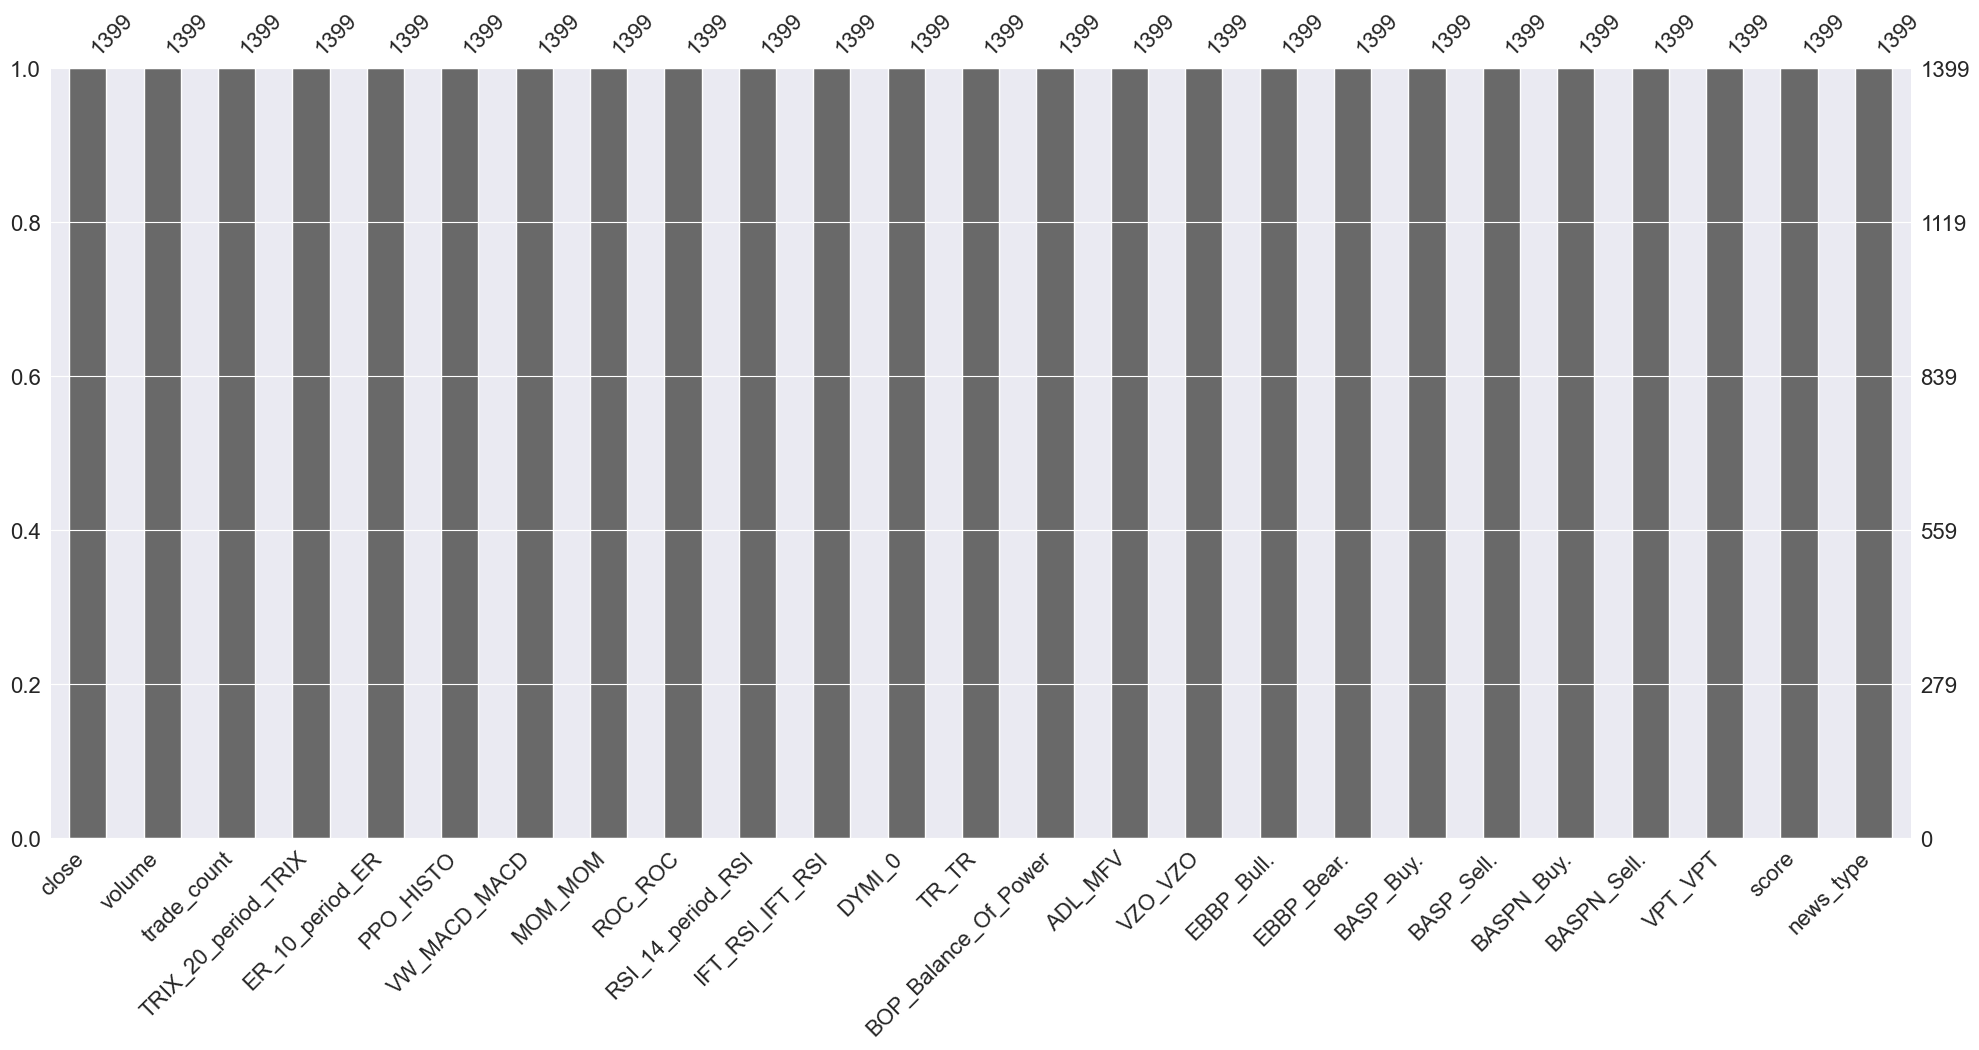

In [38]:
msno.bar(df_corr)

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>],
       [<Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'VW_MACD_MACD'}>,
        <Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>,
        <Axes: title={'center': 'RSI_14_period_RSI'}>],
       [<Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'DYMI_0'}>,
        <Axes: title={'center': 'TR_TR'}>,
        <Axes: title={'center': 'BOP_Balance_Of_Power'}>,
        <Axes: title={'center': 'ADL_MFV'}>],
       [<Axes: title={'center': 'VZO_VZO'}>,
        <Axes: title={'center': 'EBBP_Bull.'}>,
        <Axes: title={'center': 'EBBP_Bear.'}>,
        <Axes: title={'center': 'BASP_Buy.'}>,
        <Axes: title={'center': 'BASP_Sell.'}>],
       [<Axes: title={'center

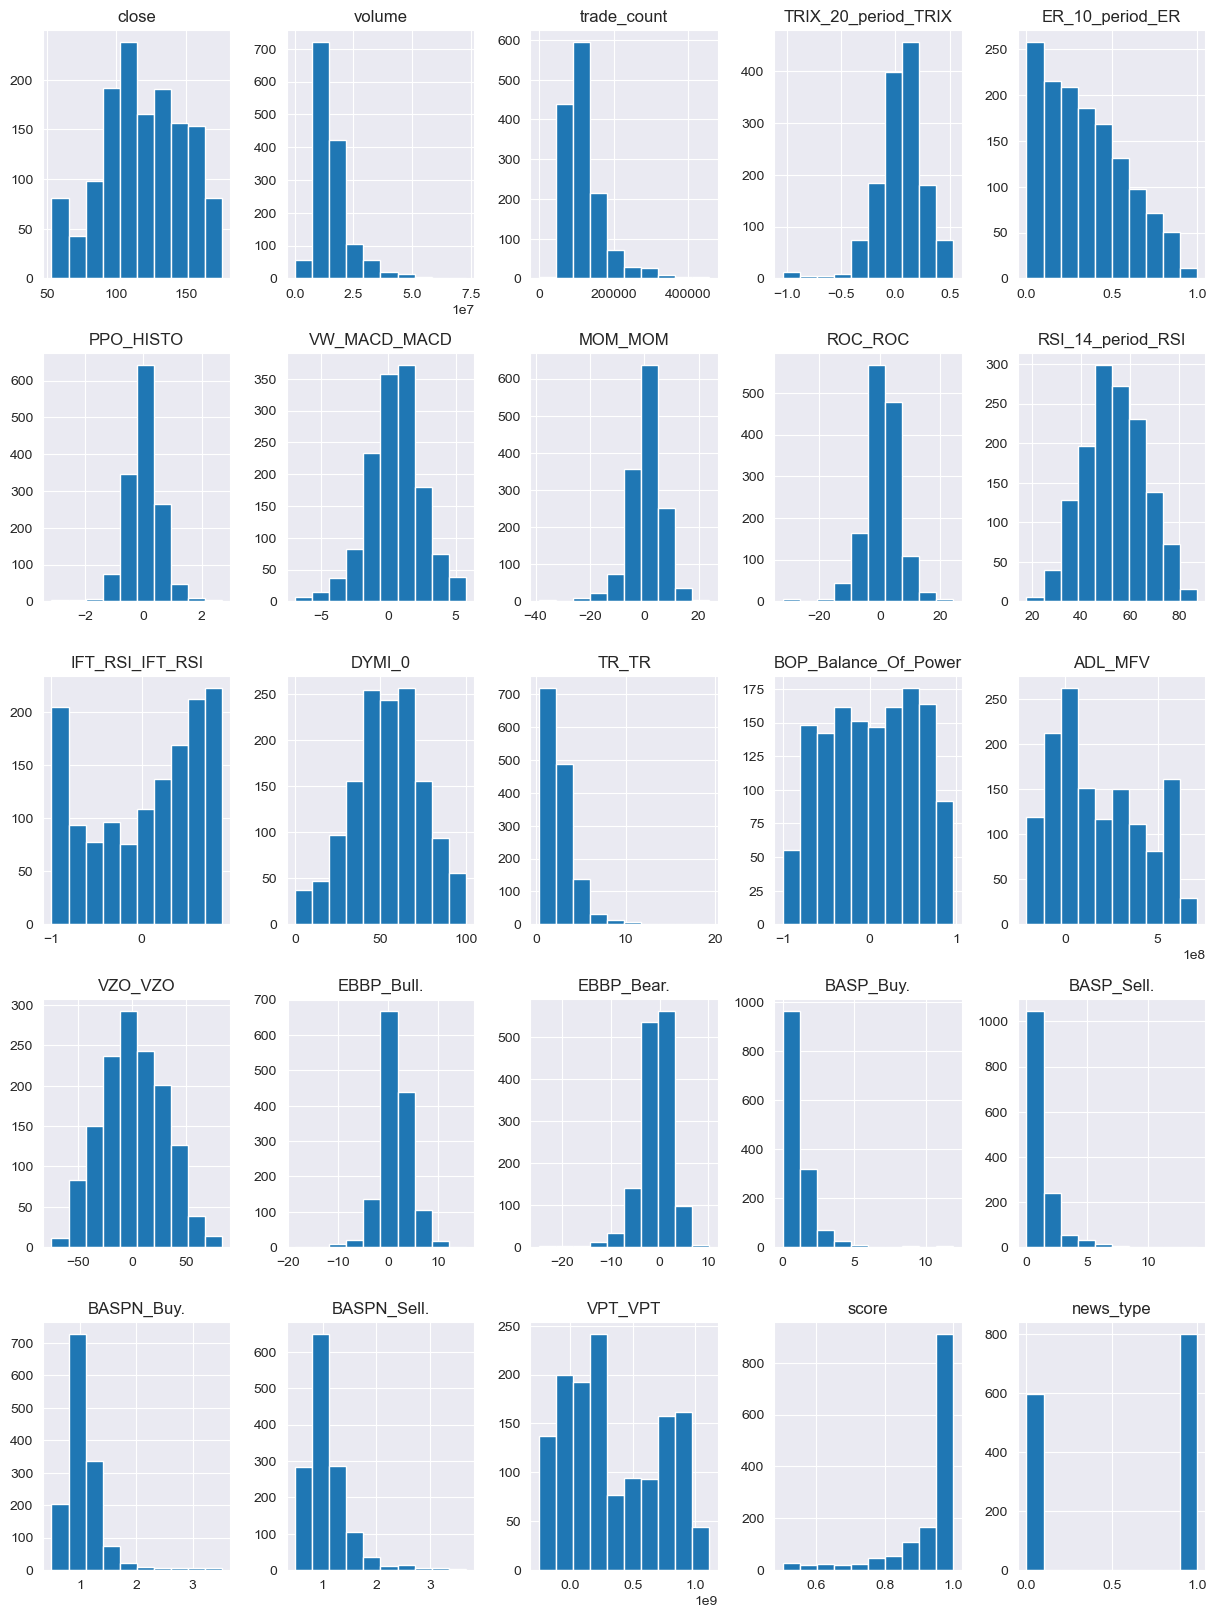

In [27]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_corr.hist(ax=ax)

#### from the dataframe describe mean and std are not 0 and 1, and from the histogram we can see the dataset is skewed on left and right

In [28]:
# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df)
df_norm = pd.DataFrame(trans_array)
named_columns = df_corr.columns
numer_couluns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_couluns, named_columns))]
colums = dict(tuples)
df_norm.rename(columns=colums, inplace=True)
df_norm.describe()

close        volume  trade_count  TRIX_20_period_TRIX  \
count  1399.000000  1.399000e+03  1399.000000          1399.000000   
mean      0.000032  4.062089e-05     0.000288             0.000065   
std       1.014201  1.013910e+00     1.014819             1.014198   
min      -5.199338 -5.199338e+00    -5.199338            -5.199338   
25%      -0.673881 -6.740067e-01    -0.674416            -0.674879   
50%      -0.001255  8.348749e-16    -0.000418             0.000418   
75%       0.674502  6.746294e-01     0.674064             0.674460   
max       5.199338  5.199338e+00     5.199338             5.199338   

       ER_10_period_ER    PPO_HISTO  VW_MACD_MACD      MOM_MOM      ROC_ROC  \
count      1399.000000  1399.000000   1399.000000  1399.000000  1399.000000   
mean         -0.000018    -0.000320      0.000128    -0.003023    -0.000055   
std           1.014108     1.015306      1.014270     1.026057     1.014561   
min          -5.199338    -5.199338     -5.199338    -5.199338    -5.199338   
25%          -0.674344    -0.674735     -0.674675    -0.673702    -0.674666   
50%           0.000829    -0.000193      0.000346     0.000627    -0.000138   
75%           0.674136     0.674855      0.674142     0.675196     0.674485   
max           5.199338     5.199338      5.199338     5.199338     5.199338   

       RSI_14_period_RSI  ...           41           42           43  \
count        1399.000000  ...  1399.000000  1399.000000  1399.000000   
mean            0.000023  ...    -0.017763    -0.017750     0.000012   
std             1.014308  ...     1.081046     1.081195     1.014276   
min            -5.199338  ...    -5.199338    -5.199338    -5.199338   
25%            -0.673748  ...    -0.674313    -0.674856    -0.674236   
50%             0.000233  ...    -0.000730    -0.000659     0.000668   
75%             0.674182  ...     0.673886     0.673996     0.674010   
max             5.199338  ...     5.199338     5.199338     5.199338   

                44           45           46           47           48  \
count  1399.000000  1399.000000  1399.000000  1399.000000  1399.000000   
mean      0.000052     0.000044     0.000074     0.000079     0.000020   
std       1.014229     1.014137     1.014201     1.014188     1.013954   
min      -5.199338    -5.199338    -5.199338    -5.199338    -5.199338   
25%      -0.674849    -0.674569    -0.674806    -0.674249    -0.674471   
50%      -0.000130     0.000550    -0.000416    -0.000178     0.000853   
75%       0.674137     0.673877     0.674751     0.673390     0.674268   
max       5.199338     5.199338     5.199338     5.199338     5.199338   

                49           50  
count  1399.000000  1399.000000  
mean     -0.000207     0.754443  
std       1.015226     5.146150  
min      -5.199338    -5.199338  
25%      -0.674348    -5.199338  
50%       0.000493     5.199338  
75%       0.674376     5.199338  
max       5.199338     5.199338  

[8 rows x 51 columns]

##### As we can see from the describe pandas method, the mean is 0 and std is 1, so our dataset has a normal distribution

In [29]:
# Correlation of Normalise Dataset
corr_matrix_norm = pd.DataFrame(df_norm.corr())
corr_matrix_norm = corr_matrix_norm.round(decimals=2)
create_table(corr_matrix_norm['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

### Modeling

In [30]:

X_norm = df_corr.drop(columns=['close'], axis=1)
y_norm = df_corr['close']
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)

In [31]:
X_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)

In [32]:
y_val.sort_index(inplace=True)
y_train.sort_index(inplace=True)

In [33]:
poly_ordinal_ohe_4 = make_column_transformer((PolynomialFeatures(include_bias=False, degree=4), make_column_selector(dtype_include=np.number)))

linreg = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_train, y_train)

alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge1.fit(X_train, y_train)

lasso = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('lasso_reg', Lasso(random_state=42))])
lasso.fit(X_train, y_train)

param_grid = {
    'clf__alpha': [0.1, 1, 10, 0.01],
    'clf__tol': [0.0001, 0.001]
}
pipeline_grid = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', MinMaxScaler()), ('clf', HuberRegressor())])
shuffle_split = StratifiedShuffleSplit(test_size=0.25, train_size=0.75, n_splits=35, random_state=87951)
grid_search = GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

rfr = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(max_depth=2, random_state=0))])
rfr.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B67C4D51D0>)])),
                ('scaler', StandardScaler()),
                ('rfr', RandomForestRegressor(max_depth=2, random_state=0))])

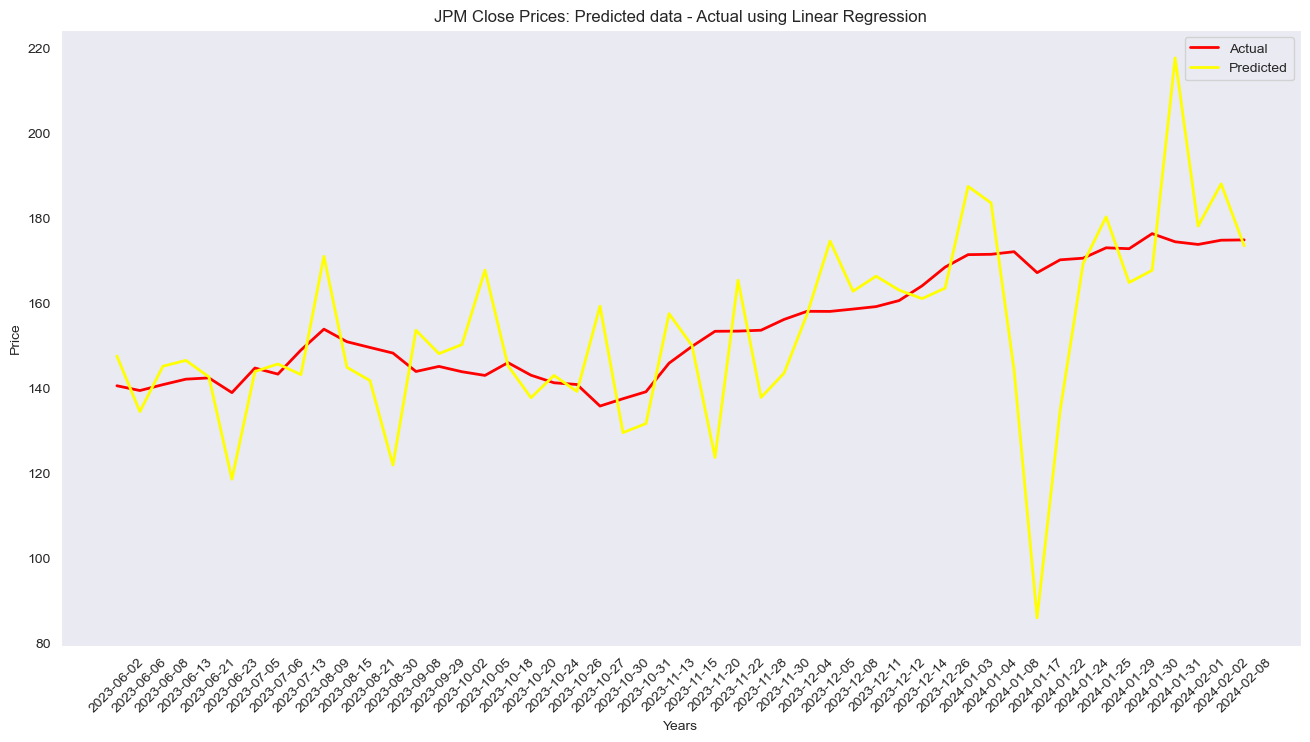

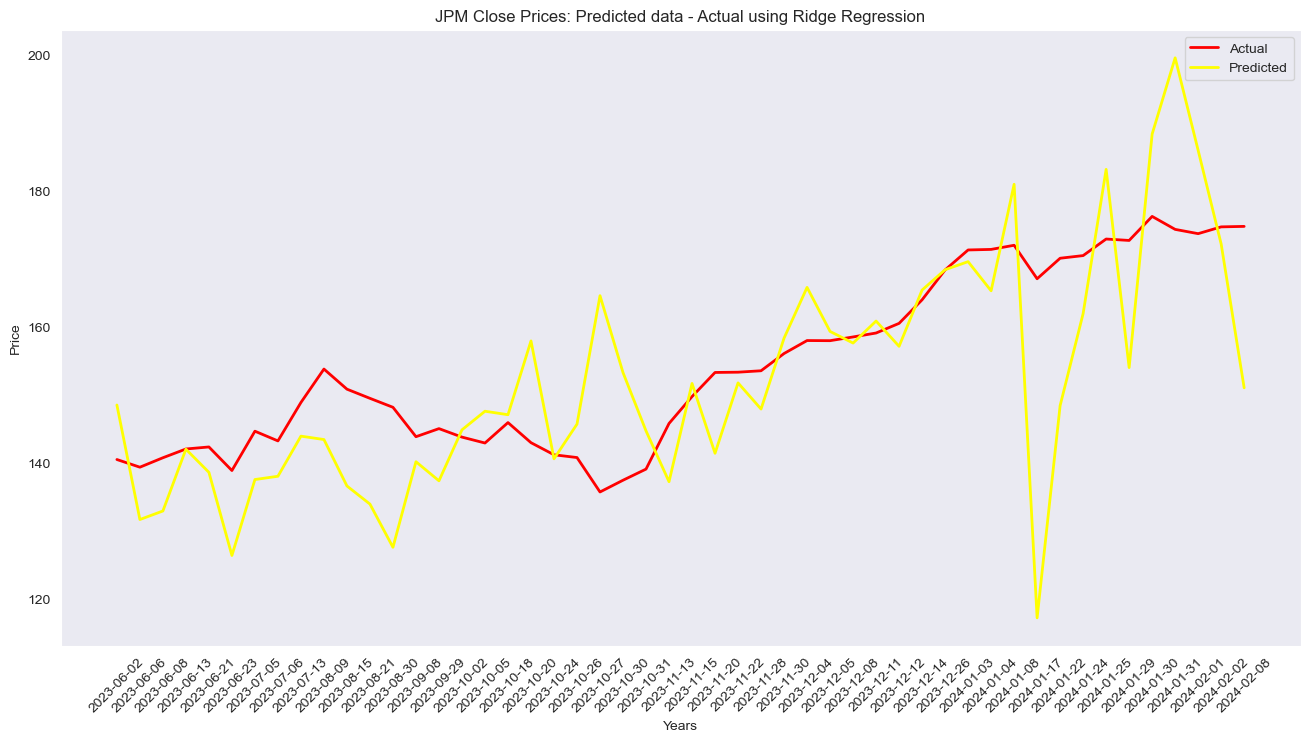

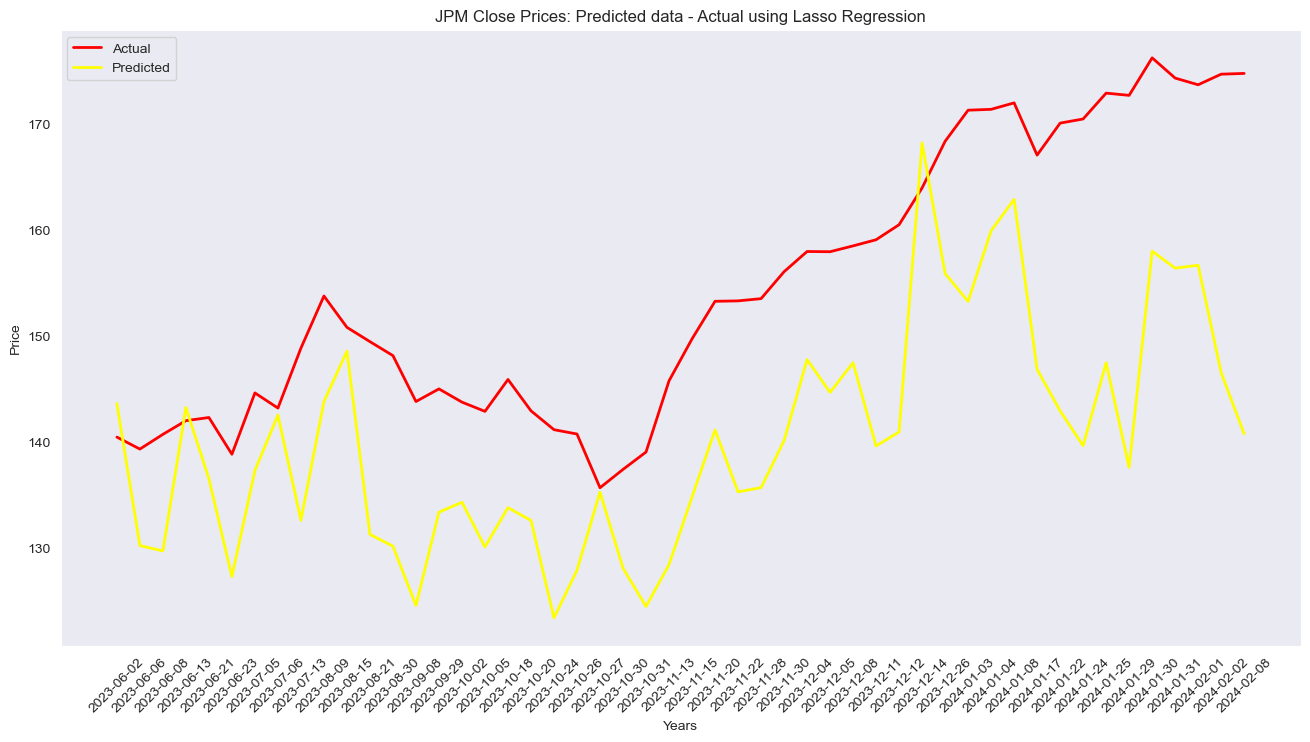

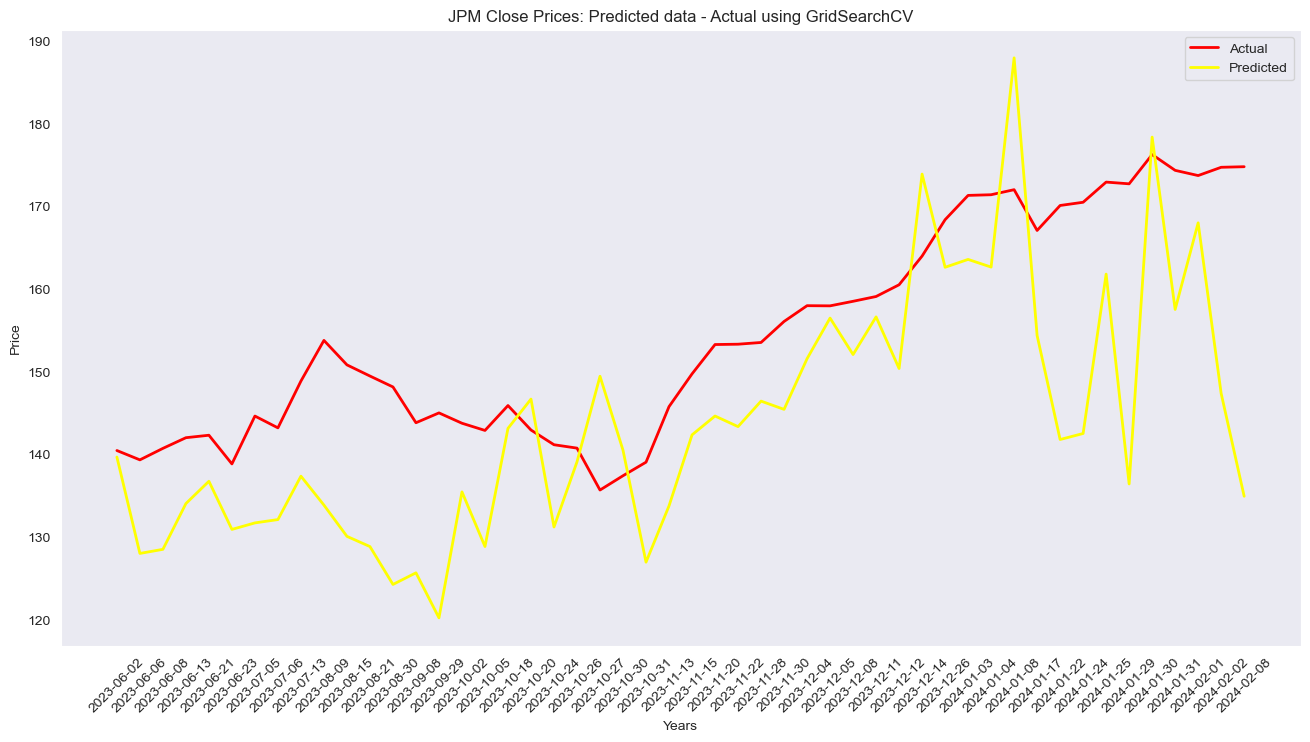

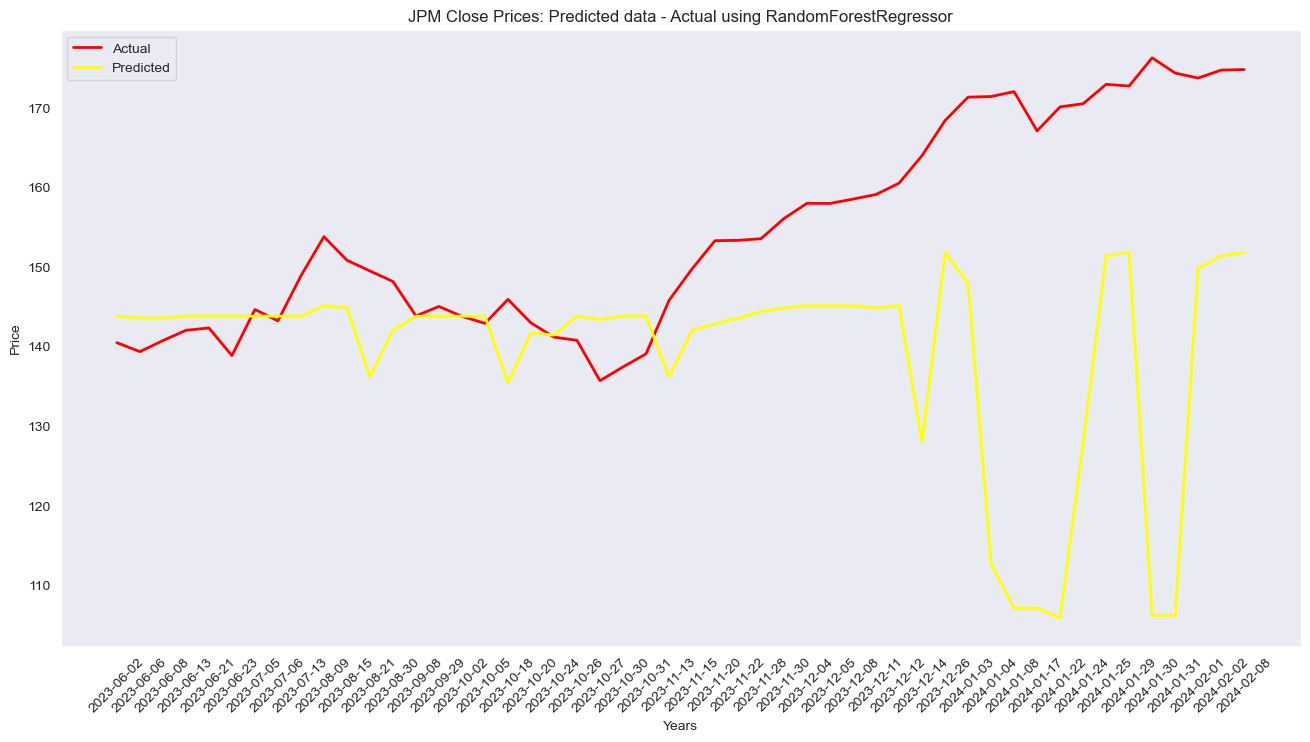

In [34]:
regression_models = {'Linear Regression': linreg,
                     'Ridge Regression': ridge1,
                     'Lasso Regression': lasso,
                     'GridSearchCV': grid_search,
                     'RandomForestRegressor': rfr
                     }
reg_model_metrics(regression_models, X_train, X_val, y_train, y_val)